# Amazon Review Summarization And Classification
# Group: Binbin Xia, Bingbing Pan, Boying Liu, Jialin Liang, Yueying Qu

In [77]:
import numpy as np
import pandas as pd 
import gzip
import json
import re
import string
from time import time
import spacy
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import sklearn.metrics as metrics
import fasttext
from random import randint
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn import naive_bayes
import nltk
from nltk.translate.bleu_score import sentence_bleu

## Problem Statement

The project intends to improve customer feedback management system. It would be helpful for any organization to understand customer feedbacks quickly, and thus can be utilized for feedback management system. Company can get a complete idea on feedback provided by customers, which makes more loyal customers to the company, expand business, fame, brand value, and profits.

## Dataset Introduction
This file has reviewer ID , User ID, Reviewer Name, Reviewer text, helpful, Summary(obtained from Reviewer text),Overall Rating on a scale 5, Review time
Description of columns in the file:

- verified - if the review has been verified
- reviewTime - date of the review being posted
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- reviewText - text of the review
- summary - summary of the review
- unixReviewTime - time of the review (unix time)

In [101]:
def parse(path):
   g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

data = getDF('Musical_Instruments_5.json.gz')

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231392 entries, 0 to 231391
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         231392 non-null  float64
 1   verified        231392 non-null  bool   
 2   reviewTime      231392 non-null  object 
 3   reviewerID      231392 non-null  object 
 4   asin            231392 non-null  object 
 5   reviewerName    231367 non-null  object 
 6   reviewText      231344 non-null  object 
 7   summary         231341 non-null  object 
 8   unixReviewTime  231392 non-null  int64  
 9   vote            34777 non-null   object 
 10  style           121310 non-null  object 
 11  image           3889 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 21.4+ MB


In [103]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 30, 2016",A3FO5AKVTFRCRJ,0739079891,francisco,It's good for beginners,Five Stars,1477785600,NaN,NaN,NaN
1,5.0,True,"06 30, 2016",A3UCGC1DHFMBCE,0739079891,Eb Jack Murray,I recommend this starter Ukulele kit. I has e...,Five Stars,1467244800,NaN,NaN,NaN
2,5.0,True,"05 9, 2016",A2S9SLRYLPGYZB,0739079891,Clara LaMarr,G'daughter received this for Christmas present...,Learning new songs to play regularly,1462752000,NaN,NaN,NaN
3,4.0,True,"04 10, 2016",A15RTJWPG8OKOE,0739079891,Eagle80,"According to my order history, I bought this t...",A bargain-bin good-enough ukulele that's held ...,1460246400,NaN,NaN,NaN
4,1.0,True,"02 6, 2016",A12ET1WO3OAVU7,0739079891,Amazon Customer,Please pay attention better than I did to the ...,Poor Quality product.,1454716800,NaN,NaN,NaN


## Drop duplicated and/or empty record

- Remove record without review and/or summary
- Assign unique index to each record

In [105]:
data = data[(pd.isna(data['reviewText']) == 0) & (pd.isna(data['summary']) == 0)]
data = data.drop_duplicates(subset=['reviewText']).reset_index(drop=True)

Use the first 100k rows to speed up the training

In [106]:
data = data[['overall', 'reviewText', 'summary']][:100000]

In [107]:
data['reviewIndex'] = np.array(range(len(data)))

In [108]:
data.head()

,overall,reviewText,summary,reviewIndex
0,5.0,It's good for beginners,Five Stars,0
1,5.0,I recommend this starter Ukulele kit. I has e...,Five Stars,1
2,5.0,G'daughter received this for Christmas present...,Learning new songs to play regularly,2
3,4.0,"According to my order history, I bought this t...",A bargain-bin good-enough ukulele that's held ...,3
4,1.0,Please pay attention better than I did to the ...,Poor Quality product.,4


## Extractive Text Summarizer

Extractive summarization means identifying important sections of the text and generating them verbatim producing a subset of the sentences from the original text.

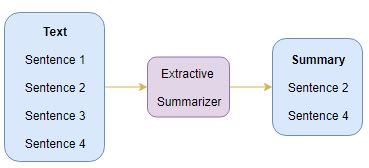

We first calcuated Jaccard similarity of each sentence in a single review and then pick up the one with the highest score as the one-line summary of the given review. 

In [9]:
def text_summarizer(review, n_summary):
    sentences = sent_tokenize(review)
    n = len(sentences)
    x = [re.split('[ ,.]',j) for j in sentences]
    jaccsim = np.array(np.zeros(n*n)).reshape((n,n))
    for i in range(n):
        for j in range(i,n):
            jaccsim[i,j] = len(set(x[i]).intersection(set(x[j])))/len(set(x[i]).union(set(x[j])))
            jaccsim[j,i] = jaccsim[i,j]
    #Summary
    idx = np.argsort(np.sum(jaccsim, axis=0))[::-1][:n_summary]  #reverse sort
    summary = [sentences[j] for j in list(idx)]
    return summary

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/xyyin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
extractive_summary = []
for review in data['reviewText']:
    extractive_summary.append(text_summarizer(review, 1))

In [111]:
data['extractive_summary'] = pd.Series(extractive_summary)

Check the result of first 5 summaries

In [13]:
for i in range(5):
    print("Review:",data['reviewText'][i])
    print("Summary:",data['extractive_summary'][i])
    print("\n")

Review: It's good for beginners
Summary: ["It's good for beginners"]


Review: I recommend this starter Ukulele kit.  I has everything you
need to learn the Ukulele.
Summary: ['I has everything you\nneed to learn the Ukulele.']


Review: G'daughter received this for Christmas present last year and plays if often.
Summary: ["G'daughter received this for Christmas present last year and plays if often."]


Review: According to my order history, I bought this this kit towards the end of 2012 as a Black Friday Week Lightning Deal. I'm writing this nearly four years later.

As with any stringed instrument, the strings really needed to stretch out before they would stay in tune. So, for the first several days, it was play a few minutes, tune, play a few minutes, tune. Then it was tuning daily. After a few weeks of this, the uke held a tune great. A tuner is not included in the package, which is the bulk of the minus star because a real beginner wouldn't have a way to tune the thing. (You need

## Abstractive Text Summarizer through a Seq2Seq LSTM Modeling

Abstractive summarization reproduces important material in a new way after interpretation and examination of the text using advanced natural language techniques to generate a new shorter text that conveys the most critical information from the original one.

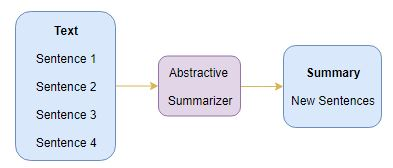

### Preprocessing Data

Task 1: Convert all characters to lowercases <br>
Task 2: Remove escape characters <br>
Task 3: Remove special characters which occurs more than one time consecutively <br>
Task 4: Remove punctuations <br> 
Task 5: Remove special characters at the end of words <br> 
Task 6: Truncate urls to keep them clean <br> 
Task 7: Remove mailto:<br>
Task 8: Remove \x9* <br>
Task 9: Clean up unimportant numbers<br>
Task 10: Remove multiple spaces<br>
Task 11: Remove any single characters hanging between 2 spaces <br>

Define a function to clean text

In [14]:
def text_cleaner(text_column):
    for text in text_column:
        new_text = text.lower() # Convert to lowercase
        new_text = re.sub(r"(\\t)", ' ', str(new_text)) #Remove tab charecters
        new_text = re.sub(r"(\\r)", ' ', str(new_text)) #Remove carriage return charecters
        new_text = re.sub(r"(\\n)", ' ', str(new_text)) #Remove newline charecters

        new_text = re.sub(r"(__+)", ' ', str(new_text))   #Remove _ if it occurs more than one time consecutively
        new_text = re.sub(r"(--+)", ' ', str(new_text))   #Remove - if it occurs more than one time consecutively
        new_text = re.sub(r"(~~+)", ' ', str(new_text))   #Remove ~ if it occurs more than one time consecutively
        new_text = re.sub(r"(\+\++)", ' ', str(new_text)) #Remove + if it occurs more than one time consecutively
        new_text = re.sub(r"(\.\.+)", ' ', str(new_text)) #Remove . if it occurs more than one time consecutively

        new_text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(new_text)) #Remove punctuations 

        new_text = re.sub("(\.\s+)", ' ', str(new_text)) #Remove . at end of words
        new_text = re.sub("(\-\s+)", ' ', str(new_text)) #Remove - at end of words
        new_text = re.sub("(\:\s+)", ' ', str(new_text)) #Remove : at end of words

        new_text = re.sub("(\s+.\s+)", ' ', str(new_text)) #Remove any single characters hanging between 2 spaces
        
        new_text = re.sub("(mailto:)", ' ', str(new_text)) #Remove mailto:
        new_text = re.sub(r"(\\x9\d)", ' ', str(new_text)) #Remove \x9* in text
        new_text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(new_text)) #Replace INC nums to INC_NUM
        new_text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(new_text)) #Replace CM# and CHG# to CM_NUM

        # Truncate urls
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(new_text))
            repl_url = url.group(3)
            new_text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(new_text))
        except:
            pass # Might be no url

        new_text = re.sub("(\s+)",' ',str(new_text)) #Remove multiple spaces

        new_text = re.sub("(\s+.\s+)", ' ', str(new_text)) #Remove any single characters hanging between 2 spaces

        yield new_text

Clean review text and summary and add these two columns to the original data frame

In [15]:
cleaning_review = text_cleaner(data['reviewText'])
cleaning_summary = text_cleaner(data['summary'])

Use spaCy .pipe() method to speed-up the cleaning process

In [16]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
review = [str(doc) for doc in nlp.pipe(cleaning_review, batch_size=5000, n_threads=-1)]

#Takes 3 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 2.68 mins


In [17]:
t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(cleaning_summary, batch_size=5000, n_threads=-1)]

#Takes 1 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.34 mins


In [112]:
data['clean_review'] = review
data['clean_summary'] = summary

In [113]:
data.head()

,overall,reviewText,summary,reviewIndex,extractive_summary,clean_review,clean_summary
0,5.0,It's good for beginners,Five Stars,0,[It's good for beginners],it good for beginners,_START_ five stars _END_
1,5.0,I recommend this starter Ukulele kit. I has e...,Five Stars,1,[I has everything you\nneed to learn the Ukule...,i recommend this starter ukulele kit has every...,_START_ five stars _END_
2,5.0,G'daughter received this for Christmas present...,Learning new songs to play regularly,2,[G'daughter received this for Christmas presen...,g daughter received this for christmas present...,_START_ learning new songs to play regularly _...
3,4.0,"According to my order history, I bought this t...",A bargain-bin good-enough ukulele that's held ...,3,"[Do it, because you're going to need it a lot ...",according to my order history bought this this...,_START_ a bargain-bin good-enough ukulele that...
4,1.0,Please pay attention better than I did to the ...,Poor Quality product.,4,[Do you self a favor and spend a little more.],please pay attention better than did to the re...,_START_ poor quality product. _END_


### Understanding the Distribution

We will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

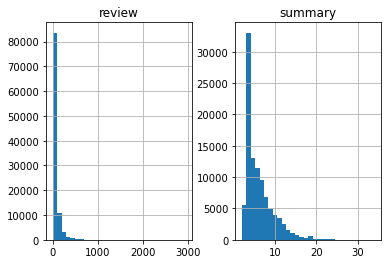

In [19]:
review_word_count = []
summary_word_count = []

for i in data['clean_review']:
      review_word_count.append(len(i.split()))

for i in data['clean_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'review':review_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

It seems like the majority of the summaries are less than or equal to 15 words and the majority of the review text are less than 100 words. Let's see what percentage of the data fall in the above-mentioned ranges.

In [20]:
cnt = 0
for i in data['clean_summary']:
    if(len(i.split()) <= 15):
        cnt = cnt + 1
print(cnt / len(data['clean_summary']))

0.97995


As what we can tell from the result, 98% of the summaries have length below 15. That's why we will fix maximum length of summary to 15.

In [21]:
cnt = 0
for i in data['clean_review']:
    if(len(i.split()) <= 100):
        cnt = cnt + 1
print(cnt / len(data['clean_review']))

0.8425


Nearly 85% of the review text have length below 100. We will ifx maximum lenght of review to 100.

In [22]:
#Model to summarize the text between 0-10 words for Summary and 0-150 words for Text
max_text_len = 100
max_summary_len = 15

In [23]:
clean_review = np.array(data['clean_review'])
clean_summary = np.array(data['clean_summary'])
indices = np.array(data['reviewIndex'])

short_review=[]
short_summary=[]
short_review_summary_indices = []

for i in indices:
    if(len(clean_summary[i].split()) <= max_summary_len and len(clean_review[i].split()) <= max_text_len):
        short_review.append(clean_review[i])
        short_summary.append(clean_summary[i])
        short_review_summary_indices.append(i)
        
df = pd.DataFrame({'index': short_review_summary_indices, 'review':short_review, 'summary':short_summary})

In order to help our model identify the start and the end of the summary, we added special tokens. We choose SOSTOK and EOSTOK as the start token and end token, repectively.

In [24]:
df['summary'] = df['summary'].apply(lambda x : 'sostok ' + x + ' eostok')

In [25]:
df.head()

,index,review,summary
0,0,it good for beginners,sostok _START_ five stars _END_ eostok
1,1,i recommend this starter ukulele kit has every...,sostok _START_ five stars _END_ eostok
2,2,g daughter received this for christmas present...,sostok _START_ learning new songs to play regu...
3,4,please pay attention better than did to the re...,sostok _START_ poor quality product. _END_ eostok
4,5,i purchased this as gift for friend who really...,sostok _START_ good starter kit _END_ eostok


### Split training set and validation set

We will use 90% of the data for training the model and hold out the remaining 10% as the validation set.

In [26]:
all_indices = list(range(len(df)))
train_indices, val_indices = train_test_split(all_indices,
                                              test_size=0.1, random_state = 1)

In [27]:
x_train = df.iloc[train_indices, 1]
y_train = df.iloc[train_indices, 2]
x_val = df.iloc[val_indices, 1]
y_val = df.iloc[val_indices, 2]

### Tokenizer

By implementing tokenizer in Keras, we converted text sequences to integer sequences, which allows us to feed the data into the model.

#### Text tokenizer

First of all, let's perform rare words analysis. If the word appears less than given times, we will consider it as a rare word. In this project, if the word appears less than 4 times in review text, we consider it as a rare word, while if the word appears less than 6 times in summary, we treat it as a rare word as well.

In [28]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [29]:
review_thresh = 4

rare_cnt = 0
tot_cnt=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if(value < review_thresh):
        rare_cnt = rare_cnt + 1
    
print("% of rare words in vocabulary:",(rare_cnt / tot_cnt)*100)

% of rare words in vocabulary: 64.61363708074337


We will only tokenize the top most common words.

In [30]:
# Prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(tot_cnt - rare_cnt)
x_tokenizer.fit_on_texts(list(x_train))

# Convert text sequences into integer sequences
x_train = x_tokenizer.texts_to_sequences(x_train) 
x_val = x_tokenizer.texts_to_sequences(x_val)

# Padding zero up to maximum length
x_train = pad_sequences(x_train,  maxlen = max_text_len, padding = 'post') 
x_val = pad_sequences(x_val, maxlen = max_text_len, padding = 'post')

# Size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 11216


#### Summary tokenizer

Perform the same procedures on summary tokenizer.

In [31]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [32]:
summary_thresh = 6

rare_cnt = 0
tot_cnt = 0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if(value < summary_thresh):
        rare_cnt = rare_cnt+1
    
print("% of rare words in vocabulary:",(rare_cnt / tot_cnt)*100)

% of rare words in vocabulary: 76.33030788396512


In [33]:
# Prepare a tokenizer for summary on training data 
y_tokenizer = Tokenizer(tot_cnt - rare_cnt)
y_tokenizer.fit_on_texts(list(y_train))

# Convert summary sequences into integer sequences
y_train = y_tokenizer.texts_to_sequences(y_train) 
y_val = y_tokenizer.texts_to_sequences(y_val) 

# Padding zero up to maximum length
y_train = pad_sequences(y_train, maxlen = max_summary_len, padding = 'post')
y_val = pad_sequences(y_val, maxlen = max_summary_len, padding = 'post')

# Size of vocabulary ( +1 for padding token)
y_voc   =  y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 2661


Remove "Summary" i.e Y (both train and val) which has only START and END.

In [34]:
ind = []
for i in range(len(y_train)):
    cnt = 0
    for j in y_train[i]:
        if j != 0:
            cnt = cnt + 1
    if(cnt == 2):
        ind.append(i)

y_train = np.delete(y_train, ind, axis=0)
x_train = np.delete(x_train, ind, axis=0)

In [35]:
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if(cnt == 2):
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

### Modelling

#### Training Phase

We built a sequence to sequence model with 3 LSTM layers in the encoder, 1 LSTM layer and 1 fully connected layer in the decoder. While we set the optimization method to RMS prop and use categorical crossentropy to measure the loss.

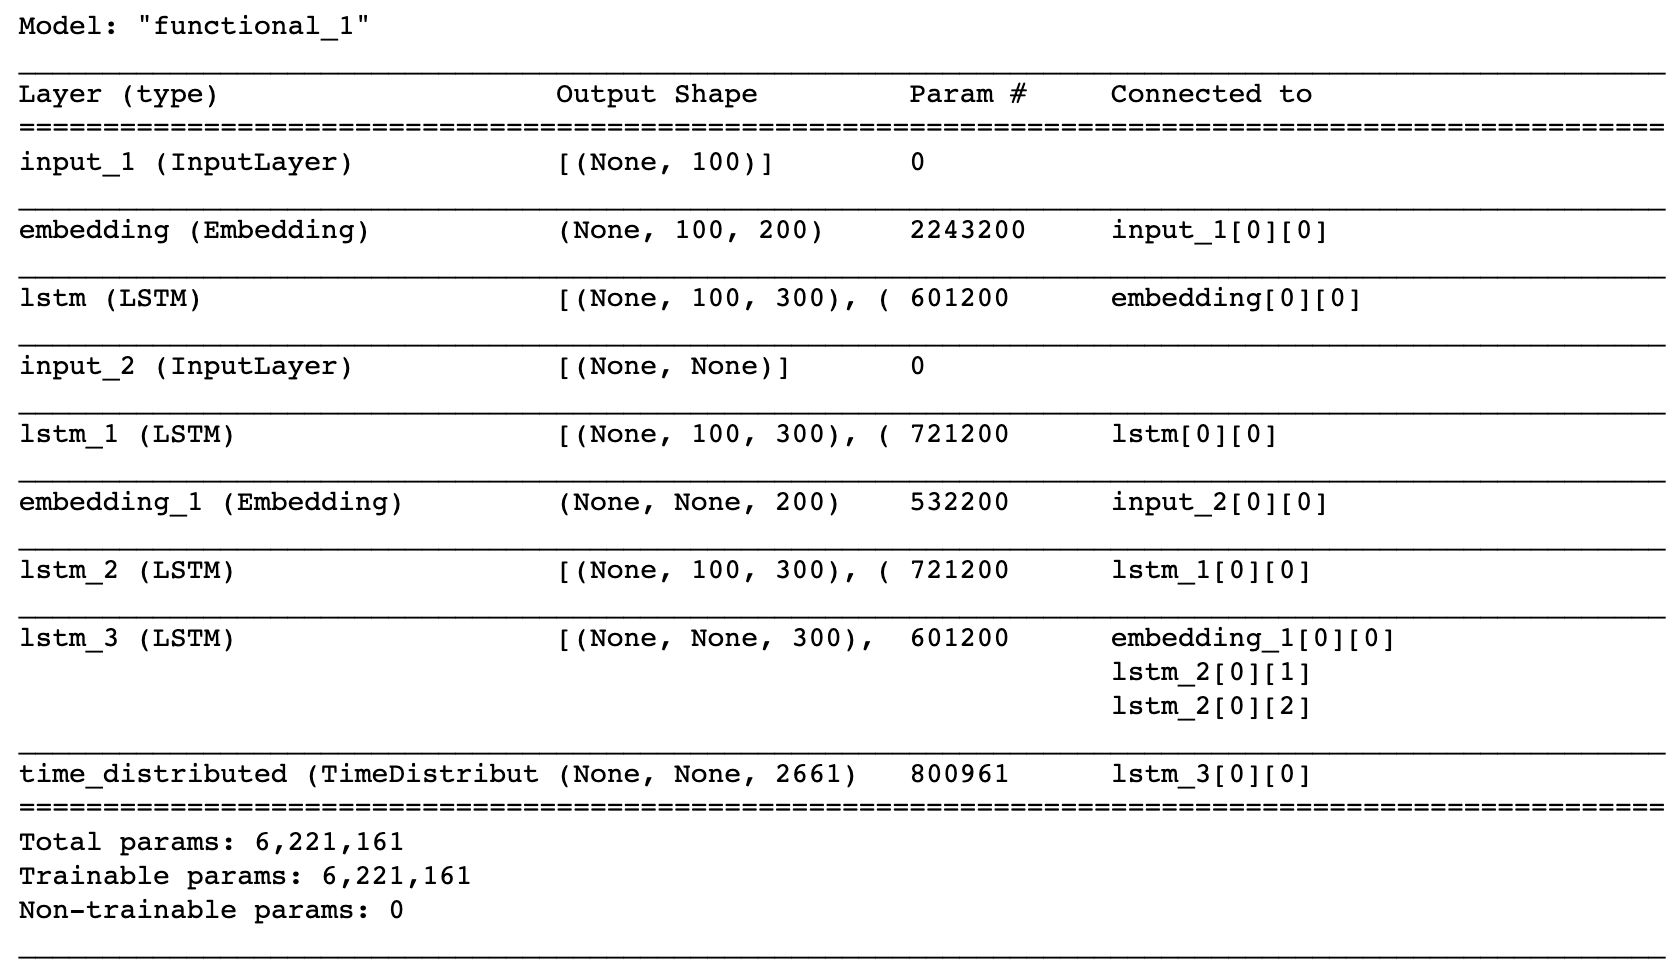

In [36]:
from keras import backend as K 
K.clear_session() 
latent_dim = 300
embedding_dim = 200

# Encoder 
encoder_inputs = Input(shape=(max_text_len,)) 
encoder_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim, return_sequences = True, return_state=True, dropout=0.4, recurrent_dropout=0.4) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim, return_sequences = True, return_state = True, dropout=0.4,recurrent_dropout=0.4) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3 = LSTM(latent_dim, return_state = True, return_sequences = True, dropout=0.4,recurrent_dropout=0.4) 
encoder_outputs3, state_h3, state_c3 = encoder_lstm3(encoder_output2) 

#Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
decoder_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
decoder_emb = decoder_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True, dropout=0.4,recurrent_dropout=0.2) 
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_emb, initial_state=[state_h3, state_c3]) 

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_outputs) 

#Define the model
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = decoder_outputs) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     2243200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [38]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)

In [40]:
history = model.fit(x = [x_train,y_train[:,:-1]], y = y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:],\
                    epochs = 50, callbacks = [es], batch_size = 256, \
                    validation_data = ([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
292/292 [==============================] - 793s 3s/step - loss: 1.7017 - val_loss: 1.4447
Epoch 2/50
292/292 [==============================] - 785s 3s/step - loss: 1.4335 - val_loss: 1.3553
Epoch 3/50
292/292 [==============================] - 782s 3s/step - loss: 1.3596 - val_loss: 1.3092
Epoch 4/50
292/292 [==============================] - 783s 3s/step - loss: 1.3126 - val_loss: 1.2746
Epoch 5/50
292/292 [==============================] - 783s 3s/step - loss: 1.2749 - val_loss: 1.2494
Epoch 6/50
292/292 [==============================] - 782s 3s/step - loss: 1.2452 - val_loss: 1.2290
Epoch 7/50
292/292 [==============================] - 782s 3s/step - loss: 1.2201 - val_loss: 1.2138
Epoch 8/50
292/292 [==============================] - 783s 3s/step - loss: 1.1978 - val_loss: 1.1990
Epoch 9/50
292/292 [==============================] - 782s 3s/step - loss: 1.1761 - val_loss: 1.1857
Epoch 10/50
292/292 [==============================] - 783s 3s/step - loss: 1.1562 - val_lo

In [41]:
model.save_weights('summarization_weights_2.h5')

In [42]:
model.save("summary_model_2")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: summary_model_2/assets


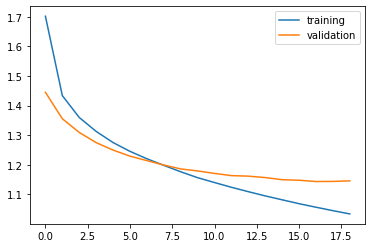

In [43]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label = 'training')
pyplot.plot(history.history['val_loss'], label = 'validation')
pyplot.legend()
pyplot.show()

The model stop at epoch 19 with the loss of 1.03 and the validation loss of 1.15.

#### Inference Phase

In [44]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs3, state_h3, state_c3])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = decoder_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

Convert index back to words

In [45]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

Define a function to decode the predicted summary

In [46]:
def decode_sequence(input_seq):
 
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token != 'eostok'):
            decoded_sentence += ' '+ sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [47]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if((i != 0 and i != target_word_index['sostok']) and i != target_word_index['eostok']):
            newString = newString + reverse_target_word_index[i] + ' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if(i!=0):
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

Check the result of the first 5 summaries

In [48]:
for i in range(5):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

Review: my go to strings 
Original summary: start five stars end 
Predicted summary:  start five stars end


Review: works great for what it is designed for 
Original summary: start works perfect end 
Predicted summary:  start works great end


Review: positions mike perfectly 
Original summary: start good and sturdy end 
Predicted summary:  start five stars end


Review: a very beefy high quality cable 
Original summary: start five stars end 
Predicted summary:  start five stars end


Review: works for both of my martin 12 string guitars in my opinion if you want longevity with these humidifiers use distilled water only tap water or treated water seems to shorten its life span 
Original summary: start herco guitar humidifier end 
Predicted summary:  start i like it but they don have to be end




Decode the predicted summaries of all reviews in validation set.

In [77]:
predicted_summaries = []
for i in range(len(x_val)):         
    predicted_summary = decode_sequence(x_val[i].reshape(1,max_text_len))
    predicted_summary = " ".join(predicted_summary.split()[1:-1])
    predicted_summaries.append(predicted_summary) 
    if i % 1000 == 0:
        print("%d records have been processed."%i)

%time

0 records have been processed.
1000 records have been processed.
2000 records have been processed.
3000 records have been processed.
4000 records have been processed.
5000 records have been processed.
6000 records have been processed.
7000 records have been processed.
8000 records have been processed.
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


#### Format final data frame

Save the results of both summarizations for further evaluation and classification.

In [114]:
val_df = df.iloc[val_indices,:]
val_df['predicted_summary'] = predicted_summaries
final_df = val_df.merge(data, how = 'left', left_on = 'index', right_on = 'reviewIndex')

In [115]:
final_df["predicted_summary"].nunique()

514

In [116]:
final_df.head()

,index,review,summary_x,predicted_summary,overall,reviewText,summary_y,reviewIndex,extractive_summary,clean_review,clean_summary
0,20629,my go to strings,sostok _START_ five stars _END_ eostok,five stars,5.0,My go to strings!,Five Stars,20629,[My go to strings!],my go to strings,_START_ five stars _END_
1,70961,works great for what it is designed for,sostok _START_ works perfect _END_ eostok,works great,4.0,Works great for what it is designed for,Works perfect,70961,[Works great for what it is designed for],works great for what it is designed for,_START_ works perfect _END_
2,30587,positions mike perfectly,sostok _START_ good and sturdy _END_ eostok,five stars,5.0,positions mike perfectly,good and sturdy,30587,[positions mike perfectly],positions mike perfectly,_START_ good and sturdy _END_
3,91201,a very beefy high quality cable.,sostok _START_ five stars _END_ eostok,five stars,5.0,A very beefy high quality cable.,Five Stars,91201,[A very beefy high quality cable.],a very beefy high quality cable.,_START_ five stars _END_
4,48034,works for both of my martin 12 string guitars ...,sostok _START_ herco he360 guitar humidifier _...,i like it but they don have to be,5.0,Works for both of my Martin 12 string guitars....,Herco HE360 Guitar Humidifier,48034,"[In my opinion, if you want longevity with the...",works for both of my martin 12 string guitars ...,_START_ herco he360 guitar humidifier _END_


In [117]:
final_df = final_df[["reviewIndex", "overall", "reviewText", "summary_y", \
                     "extractive_summary", "predicted_summary"]]

In [118]:
final_df.head()

,reviewIndex,overall,reviewText,summary_y,extractive_summary,predicted_summary
0,20629,5.0,My go to strings!,Five Stars,[My go to strings!],five stars
1,70961,4.0,Works great for what it is designed for,Works perfect,[Works great for what it is designed for],works great
2,30587,5.0,positions mike perfectly,good and sturdy,[positions mike perfectly],five stars
3,91201,5.0,A very beefy high quality cable.,Five Stars,[A very beefy high quality cable.],five stars
4,48034,5.0,Works for both of my Martin 12 string guitars....,Herco HE360 Guitar Humidifier,"[In my opinion, if you want longevity with the...",i like it but they don have to be


In [119]:
final_df.to_csv('results2.csv')

## Evaluation of the Summaries

In [78]:
data = pd.read_csv('results2.csv')
data = data.drop(columns = ['Unnamed: 0'])
data.dropna(inplace = True)

#### Clean the data (lower case, strip)

In [83]:
data['predicted_summary'] = data['predicted_summary'].map(lambda x: x.strip("[' ']"))
data['extractive_summary'] = data['extractive_summary'].str.lower()
data['extractive_summary'] = data['extractive_summary'].map(lambda x: x.strip("[' ']"))
data['summary_y_lower'] = data['summary_y'].str.lower()
data['summary_y_lower'] = data['summary_y_lower'].apply(lambda x: x.split(','))
data.head()

,reviewIndex,overall,reviewText,summary_y,extractive_summary,predicted_summary,summary_y_lower
0,20629,5.0,My go to strings!,Five Stars,my go to strings!,five stars,[five stars]
1,70961,4.0,Works great for what it is designed for,Works perfect,works great for what it is designed for,works great,[works perfect]
2,30587,5.0,positions mike perfectly,good and sturdy,positions mike perfectly,five stars,[good and sturdy]
3,91201,5.0,A very beefy high quality cable.,Five Stars,a very beefy high quality cable.,five stars,[five stars]
4,48034,5.0,Works for both of my Martin 12 string guitars....,Herco HE360 Guitar Humidifier,"in my opinion, if you want longevity with thes...",i like it but they don have to be,[herco he360 guitar humidifier]


#### Bleu Score - Extractive Summary

In [84]:
data['BLEU1'] = data.apply(lambda row: sentence_bleu(row['summary_y_lower'],row['extractive_summary']), axis=1)

In [88]:
print('Average Bleu score for extractive summary is:', round(data['BLEU1'].mean(axis=0), 2))

Average Bleu score for extractive summary is: 0.11


#### Bleu Score - Abstractive Summary

In [86]:
data['BLEU2'] = data.apply(lambda row: sentence_bleu(row['summary_y_lower'],row['predicted_summary']), axis=1)

In [89]:
print('Average Bleu score for abstractive summary is:', round(data['BLEU2'].mean(axis=0), 2))

Average Bleu score for abstractive summary is: 0.23


After comparing the bleu scores of extractive summary and abstractive summary, we decided to move forward with abstractive summary for further classification.

## Summary Classification

#### Process Data

In [65]:
data = pd.read_csv('results2.csv')
data = data.drop(columns = ['Unnamed: 0'])
data.dropna(inplace = True)


Label data for Fasttext classification
 - _label_2: negative
 - _label_0: neutral
 - _label_1: positive

In [66]:
data['sentiment'] = data.overall.replace({
    1:'__label__2',
    2:'__label__2',
    3:'__label__0',
    4:'__label__1',
    5:'__label__1'
})

Split data for classification

In [68]:
df = data[['sentiment', 'predicted_summary']]
data_X = data['predicted_summary']
y_data = data['sentiment']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(data_X, y_data, test_size=0.25, random_state= 1)

In [70]:
d = {'sentiment': y_train, 'predicted_summary': X_train}
temp= pd.DataFrame(data=d)
temp.to_csv('review_train.txt', sep=" ", header=False, index=False)
d = {'sentiment': y_test, 'predicted_summary': X_test}
tmp= pd.DataFrame(data=d)
tmp.to_csv('review_test.txt', sep=" ", header=False, index=False)

#### Fasttext

In [50]:
model = fasttext.train_supervised('review_train.txt', epoch=50)

In [51]:
train = pd.read_csv("review_train.txt", sep = " ", header=None)
test = pd.read_csv("review_test.txt", sep = " ", header=None)
train.columns = ['sentiment','predicted_summary']
test.columns = ['sentiment','predicted_summary']

In [52]:
yhat = [model.predict(train.loc[k][1])[0][0] for k in range(len(train))]
y0 = list(train.iloc[:,0])

print(metrics.classification_report(y0, yhat))

              precision    recall  f1-score   support

  __label__0       0.04      0.01      0.02       429
  __label__1       0.88      0.98      0.93      5452
  __label__2       0.92      0.03      0.06       329

    accuracy                           0.87      6210
   macro avg       0.61      0.34      0.34      6210
weighted avg       0.82      0.87      0.82      6210



#### Multinomial Naive Bayes

In [74]:
text_mvb = make_pipeline(TfidfVectorizer(), naive_bayes.MultinomialNB())
text_mvb.fit(X_train, y_train)
predictions = text_mvb.predict(X_test)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

  __label__0       0.06      0.01      0.01       143
  __label__1       0.88      0.98      0.93      1789
  __label__2       0.66      0.28      0.39       139

    accuracy                           0.87      2071
   macro avg       0.53      0.42      0.45      2071
weighted avg       0.81      0.87      0.83      2071



#### XGBoost

In [75]:
text_xgb = make_pipeline(TfidfVectorizer(), xgb.XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective='multi:softmax',
 nthread=4,
 seed=0))
text_xgb.fit(X_train, y_train)
predictions = text_xgb.predict(X_test)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

  __label__0       0.24      0.03      0.06       143
  __label__1       0.88      0.98      0.93      1789
  __label__2       0.63      0.27      0.37       139

    accuracy                           0.87      2071
   macro avg       0.58      0.43      0.46      2071
weighted avg       0.82      0.87      0.83      2071



#### Support Vector Machine

In [76]:
text_clf = make_pipeline(TfidfVectorizer(), svm.SVC(kernel='rbf', tol=1e-3, random_state = 0))

text_clf.fit(X_train, y_train)

predictions = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

  __label__0       0.43      0.02      0.04       143
  __label__1       0.88      0.99      0.93      1789
  __label__2       0.74      0.25      0.38       139

    accuracy                           0.88      2071
   macro avg       0.68      0.42      0.45      2071
weighted avg       0.84      0.88      0.83      2071



## Evaluation of the Classfication

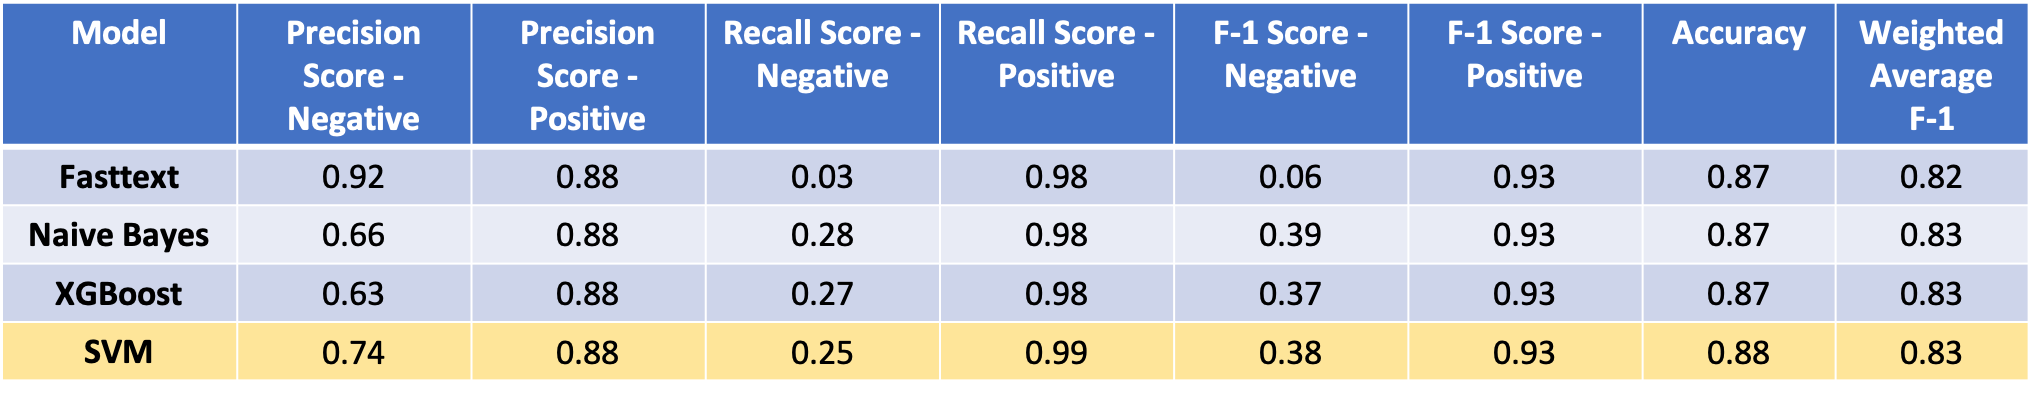

## Conlusion

The project can be applied into the Review Management System for the organization to understand customer feedbacks fast and accurate, it includes two functions: 
1. Summarize Review
2. Classify the review summarization into positive, neutral, negative categories

Abstractive summarization perform better than extractive summarizatioin. Based on the abstractive summarization result, we built 4 classification models. From these 4 classification model results above, we could see all of them are accurate and stable. Whereas SVM gives us the best review classification result. By using SVM model in this feedback management system, organizations can get a complete idea on feedback provided by customers, which makes more loyal customers to the company, expand business, fame, brand value, and profits.